In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import uuid  # To generate a unique ID for each file
from tqdm import tqdm
from scipy.sparse import block_diag
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
import random
from scipy.linalg import svd
from joblib import Parallel, delayed
from typing import List, Tuple

In [2]:
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 
               'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 
               'chr20', 'chr21', 'chr22', 'chrX']

In [3]:
def visualize(matrix, cmap='gray'):
    plt.imshow(matrix, cmap, interpolation='nearest')
    plt.colorbar(label="Value")
    plt.title("Block-Diagonal Chromosome Matrix")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

In [4]:
def parse_file(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    total_sum = data['interaction'].sum()
    cis_contacts = data[data['chr1'] == data['chr2']]['interaction'].sum()
    trans_contacts = data[data['chr1'] != data['chr2']]['interaction'].sum()
    if trans_contacts == 0:
        cis_trans_ratio = float('inf')
    else:
        cis_trans_ratio = cis_contacts / trans_contacts

    if total_sum >= 1000 and cis_trans_ratio >= 1:
        return data
    print(f"SKIPPED {file_path}")
    return None

def find_range(data, chr):
    range_pos1 = data[data['chr1'] == chr]["pos1"]
    range_pos2 = data[data['chr2'] == chr]["pos2"]
    
    max_pos1 = range_pos1.max()
    min_pos1 = range_pos1.min() 
    max_pos2 = range_pos2.max() 
    min_pos2 = range_pos2.min() 

    max_range = max(max_pos1, max_pos2) - min(min_pos1, min_pos2)
    return int(max_range / 1000000) + 1, min(min_pos1, min_pos2)


def load_txt_to_matrix(data):
    list_of_chromosomes = []
    for chr in chromosomes:
        chr_range, min_position = find_range(data, chr)
        X_chr = np.zeros((chr_range, chr_range), dtype=int)

        for _, row in data[(data['chr1'] == chr) & (data['chr2'] == chr)].iterrows():
            if row['interaction'] > 0:
                pos1_index = int((row['pos1'] - min_position) / 1000000)
                pos2_index = int((row['pos2'] - min_position) / 1000000)
                if abs(pos1_index - pos2_index) >= 3:
                    X_chr[pos1_index, pos2_index] = 1
                # else:
                #     X_chr[pos1_index, pos2_index] = -1

        list_of_chromosomes.append(X_chr)
    return list_of_chromosomes

In [46]:
sample = parse_file("GM12878/ml3_AAGCGACC-ACCTCTTG.txt")
sample_matrix_list = load_txt_to_matrix(sample)

In [ ]:
sample_matrix_list

In [17]:
# for i in range(23):
#     print(sample_matrix_list[i].shape)

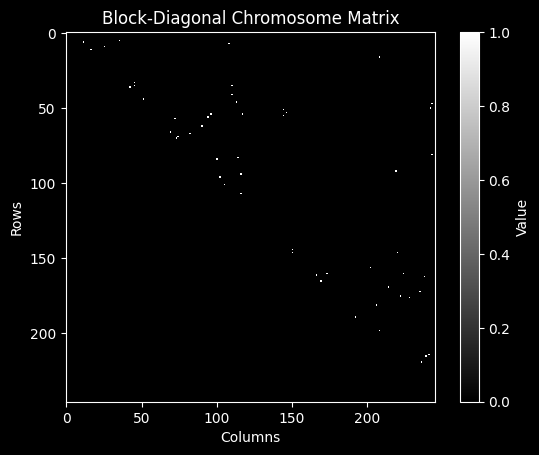

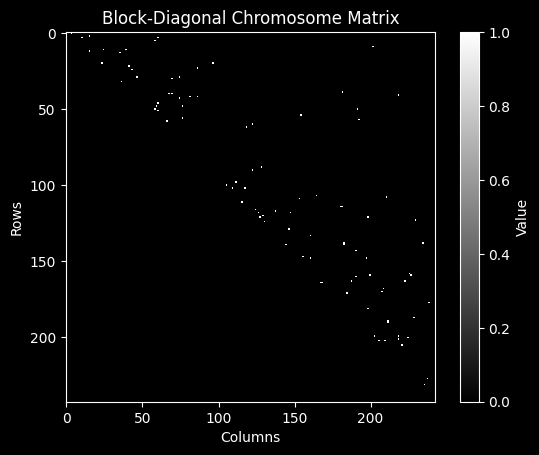

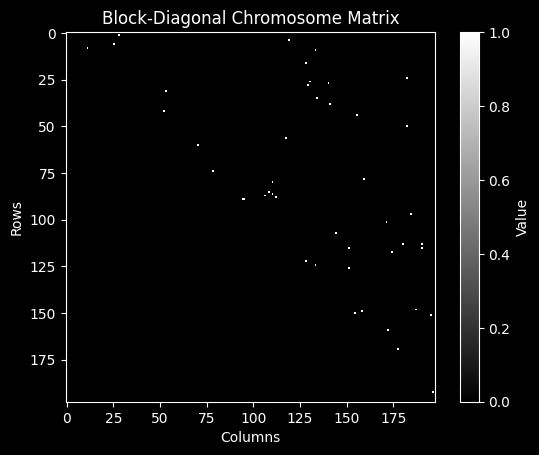

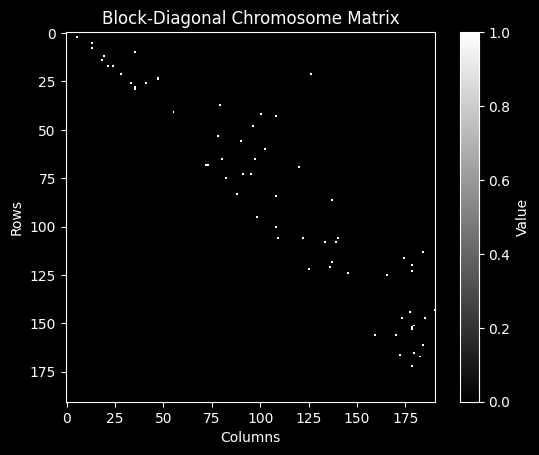

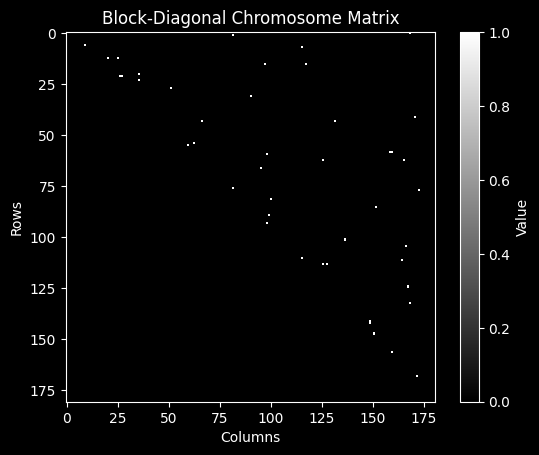

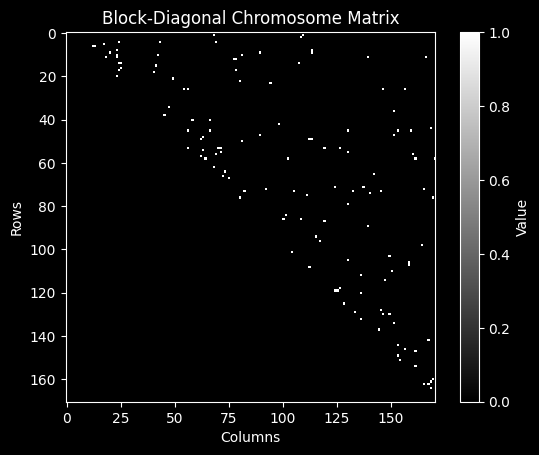

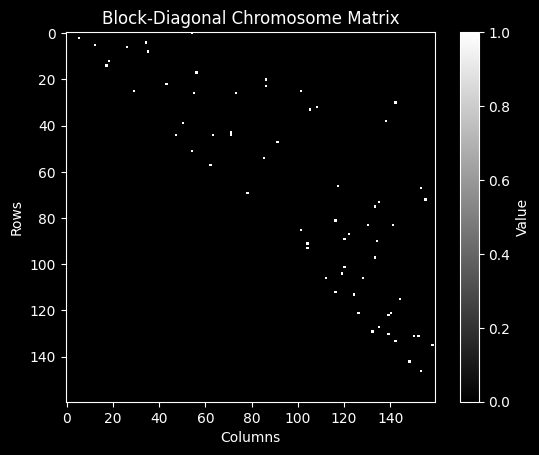

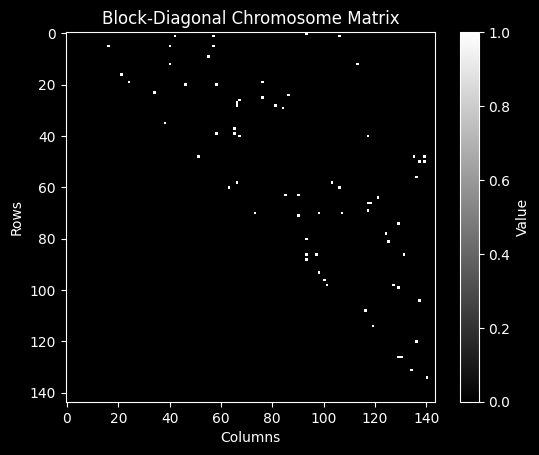

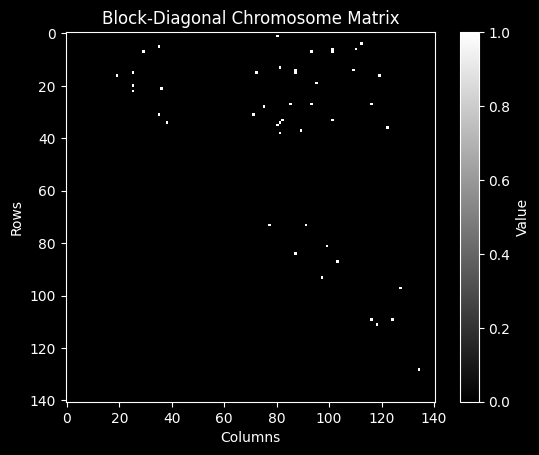

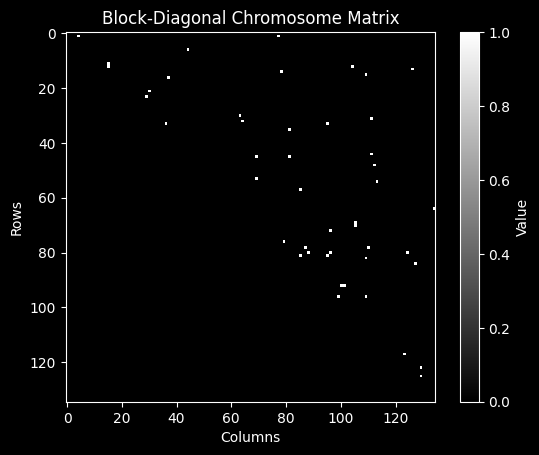

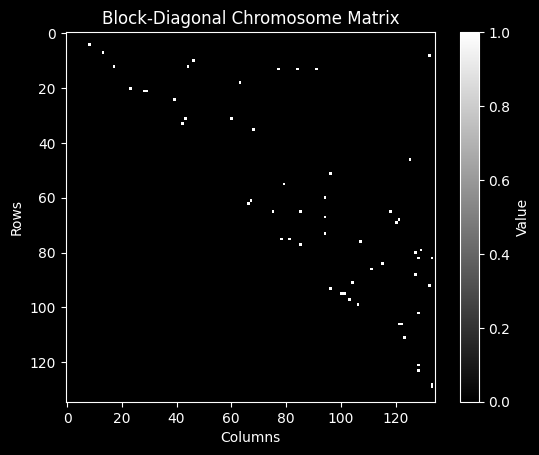

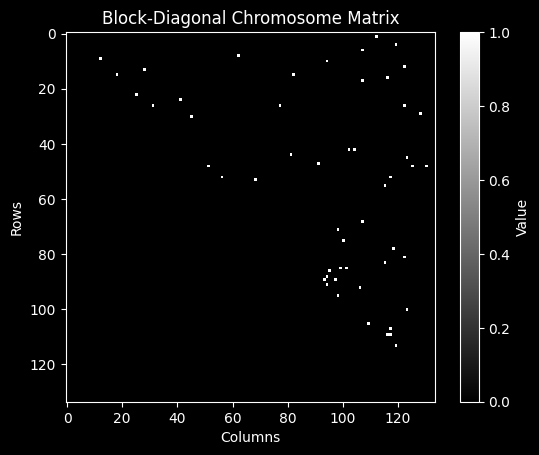

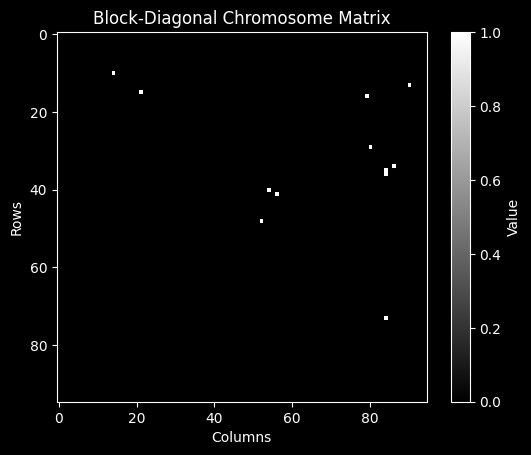

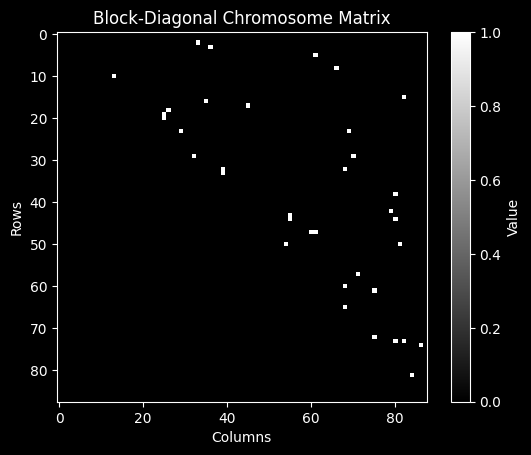

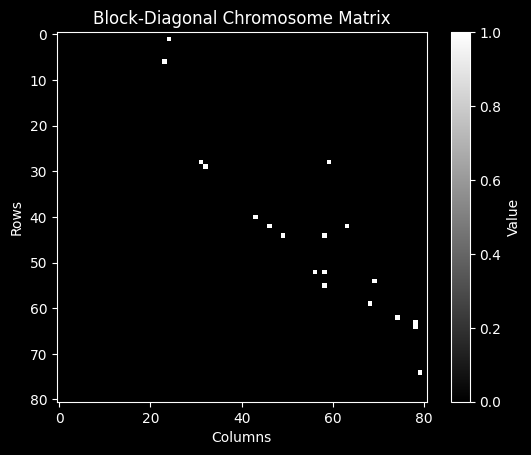

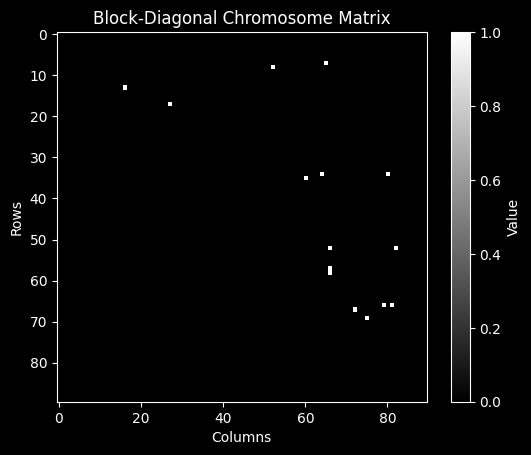

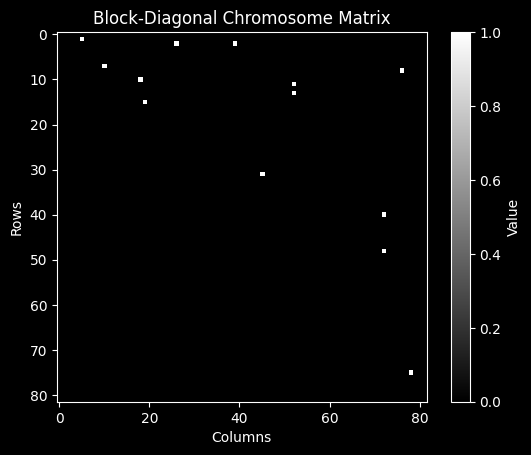

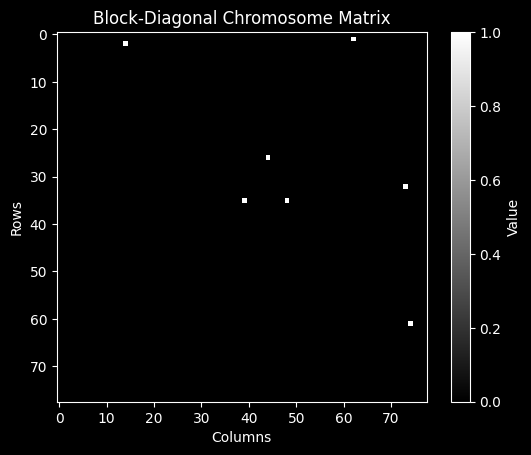

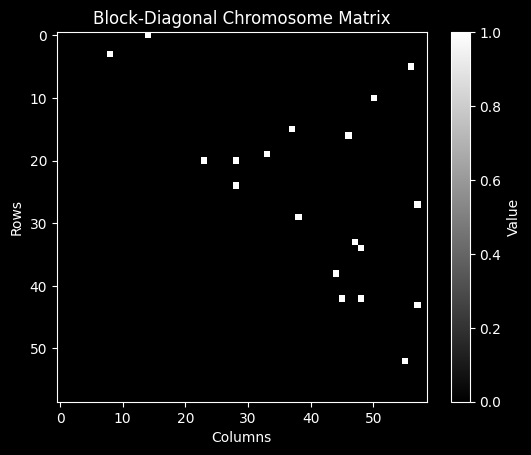

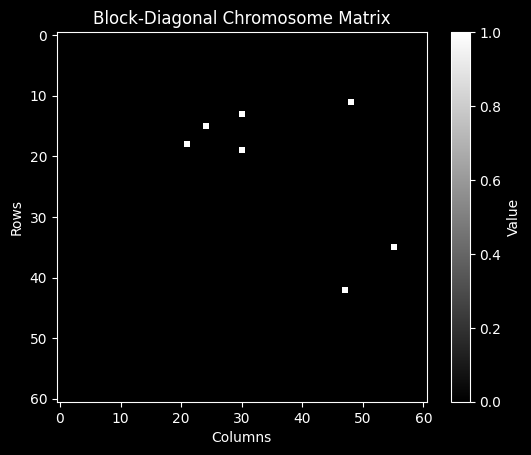

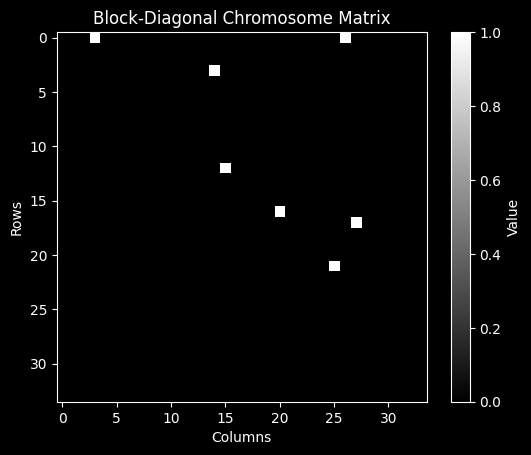

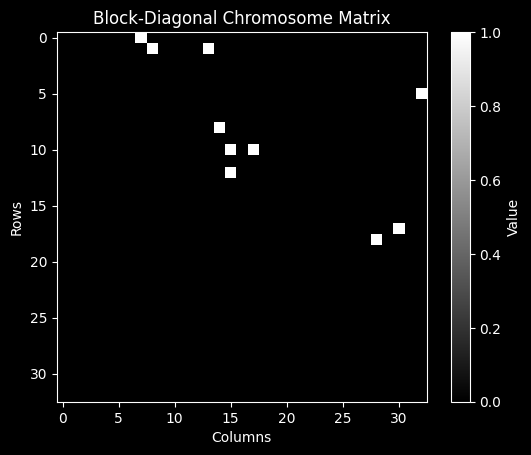

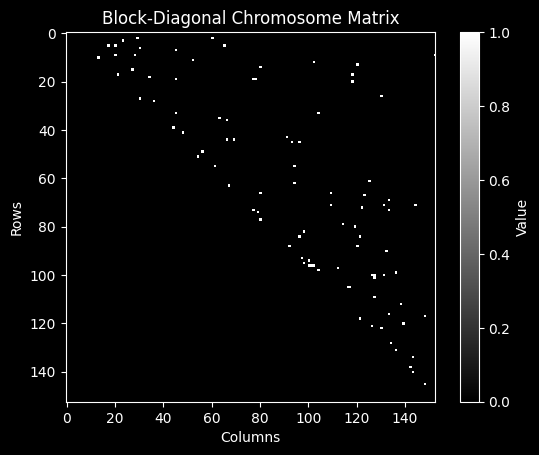

In [51]:
for i in range(23):
    visualize(sample_matrix_list[i])

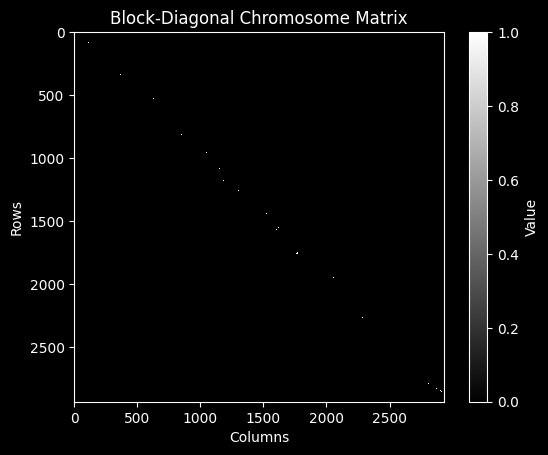

In [52]:
combined_matrix = block_diag(sample_matrix_list).toarray()
visualize(combined_matrix)

In [49]:
GM12878_MATRICES = []
HAP1_MATRICES = []
Hela_MATRICES = []
K562_MATRICES = []

for file in tqdm(os.listdir("GM12878")):
    if file.endswith(".txt"):
        data = parse_file(f"GM12878/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            GM12878_MATRICES.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("HAP1")):
    if file.endswith(".txt"):
        data = parse_file(f"HAP1/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            HAP1_MATRICES.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("Hela")):
    if file.endswith(".txt"):
        data = parse_file(f"Hela/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            Hela_MATRICES.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("K562")):
    if file.endswith(".txt"):
        data = parse_file(f"K562/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            K562_MATRICES.append(block_diag(matrix_in_list).toarray())

100%|██████████| 48/48 [00:04<00:00, 10.11it/s]


In [5]:
# Function to perform PCA decomposition and return the reduced matrix and reconstructed matrix
def pca_reconstruct_and_distance(matrix, n_components=50):
    # Step 1: Center and normalize the matrix
    scaler = StandardScaler(with_mean=True, with_std=True)
    normalized_matrix = scaler.fit_transform(matrix)

    # Step 2: Apply PCA to reduce to `n_components` components
    pca = PCA(n_components=n_components)
    reduced_matrix = pca.fit_transform(normalized_matrix)
    
    # Step 3: Reconstruct the matrix back to the original dimensions
    reconstructed_matrix = pca.inverse_transform(reduced_matrix)
    
    # Step 4: Reverse normalization on the reconstructed matrix to match the original scale
    reconstructed_matrix = scaler.inverse_transform(reconstructed_matrix)
    
    # Step 5: Calculate the Frobenius norm (distance) between the original and reconstructed matrices
    distance = norm(matrix - reconstructed_matrix, ord='fro')
    
    return distance

In [6]:
# Function to calculate total distance for a list of matrices
def calculate_total_distance(matrix_list, n_components=50, sample_num=20):
    """
    Samples a subset of matrices from the provided list, computes the Frobenius distance
    for each, and returns the total sum of distances.
    
    Parameters:
    - matrix_list (list of np.ndarray): List containing matrices.
    - n_components (int): Number of principal components to retain in PCA.
    - sample_num (int): Number of matrices to sample from the list.
    
    Returns:
    - float: Total sum of Frobenius distances for the sampled matrices.
    """
    # Ensure sample_num does not exceed the number of available matrices
    sample_num = min(sample_num, len(matrix_list))
    
    # Sample a subset of matrices without replacement
    sampled_matrices = random.sample(matrix_list, sample_num)

    total_distance = 0.0
    for matrix in sampled_matrices:
        distance = pca_reconstruct_and_distance(matrix, n_components=n_components)
        total_distance += distance
    return total_distance

In [75]:
# Define the fraction or number of matrices to sample
sample_num = 20

# Sample a subset from HAP1 and Hela matrices
HAP1_sample = random.sample(HAP1_MATRICES, sample_num)
Hela_sample = random.sample(Hela_MATRICES, sample_num)
GM12878_sample = random.sample(GM12878_MATRICES, sample_num)
K562_sample = random.sample(K562_MATRICES, sample_num)


In [79]:
def plot_rank_to_loss():
    # Define the ranks to evaluate
    ranks = list(range(5, 51, 5))  # [5, 10, 15, ..., 50]
    sum_distances = []

    # Organize the matrices by cell line
    cell_lines = {
        'HAP1': HAP1_sample,
        'Hela': Hela_sample,
        'GM12878': GM12878_sample,
        'K562': K562_sample
    }

    # Initialize progress bar
    print("Computing total sum of Frobenius distances for each rank...")
    for rank in tqdm(ranks, desc="Ranks"):
        total_distance_sum = 0.0
        for matrix_list in cell_lines.values():
            distance = calculate_total_distance(matrix_list, n_components=rank, sample_num=20)
            total_distance_sum += distance
        sum_distances.append(total_distance_sum)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, sum_distances, marker='o', linestyle='-', color='blue')
    plt.title('Total Sum of Frobenius Distances vs PCA Rank', fontsize=14)
    plt.xlabel('Rank (Number of PCA Components)', fontsize=12)
    plt.ylabel('Total Sum of Frobenius Distances', fontsize=12)
    plt.xticks(ranks)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Computing total sum of Frobenius distances for each rank...


Ranks: 100%|██████████| 10/10 [1:39:44<00:00, 598.47s/it]


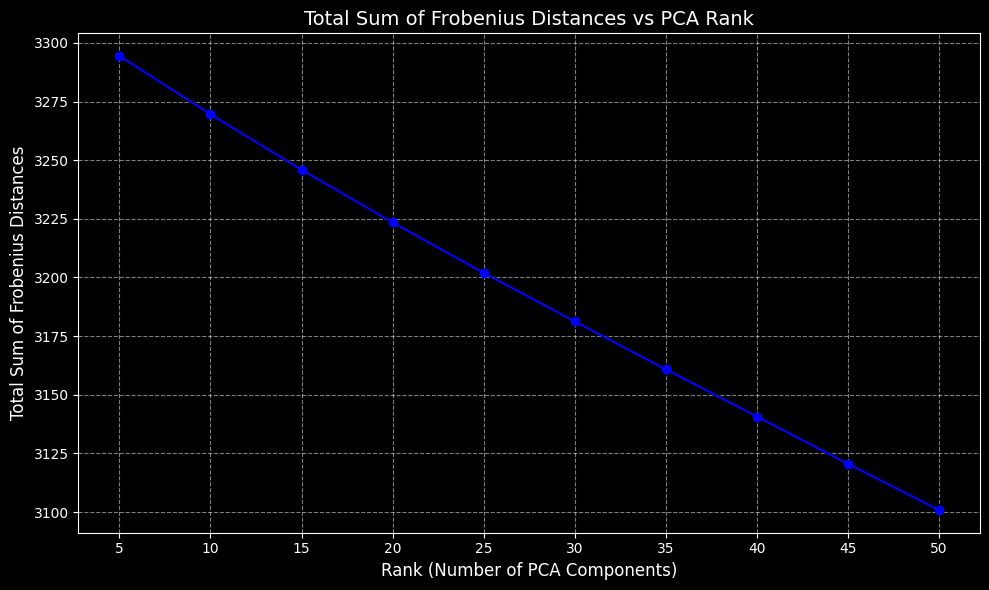

In [80]:
plot_rank_to_loss()

In [7]:
def dimensionality_reduce(matrix: np.ndarray, n_components: int = 50, standardize: bool = True):
    # Validate input dimensions
    if matrix.ndim != 2:
        raise ValueError(f"Input matrix must be 2D. Received {matrix.ndim}D.")
    
    n_samples, n_features = matrix.shape

    if n_components > n_features:
        raise ValueError(f"n_components={n_components} cannot exceed the number of features={n_features}.")

    # Standardize the data if required
    if standardize:
        scaler = StandardScaler()
        matrix_scaled = scaler.fit_transform(matrix)
    else:
        matrix_scaled = matrix.copy()

    # Initialize PCA
    pca = PCA(n_components=n_components, svd_solver='auto', random_state=42)

    # Fit PCA and transform the data
    reduced_matrix = pca.fit_transform(matrix_scaled)

    return reduced_matrix, pca


def dimensionality_reduce_list_parallel(
    matrices,
    n_components: int = 50,
    standardize: bool = True,
    n_jobs: int = -1
):
   
    def process_matrix(idx, matrix):
        try:
            reduced_matrix, pca_model = dimensionality_reduce(matrix, n_components, standardize)
            return reduced_matrix, pca_model
        except ValueError as ve:
            print(f"ValueError for matrix {idx + 1}: {ve}")
            return None, None
        except Exception as e:
            print(f"An error occurred while processing matrix {idx + 1}: {e}")
            return None, None

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_matrix)(idx, matrix) for idx, matrix in enumerate(matrices)
    )

    # Unpack results
    reduced_matrices, pca_models = zip(*results)

    # Filter out any failed reductions
    reduced_matrices = [rm for rm in reduced_matrices if rm is not None]
    pca_models = [pm for pm in pca_models if pm is not None]

    return reduced_matrices

In [126]:
GM12878_M = dimensionality_reduce_list_parallel(
    GM12878_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1  # Use all available CPU cores
)

K562_M = dimensionality_reduce_list_parallel(
    K562_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

HAP1_M = dimensionality_reduce_list_parallel(
    HAP1_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

Hela_M = dimensionality_reduce_list_parallel(
    Hela_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

/Users/yanghaochong/Documents/dna_heterogeneity/.conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [8]:
bins = {
    'chr1': 250,
    'chr2': 244,
    'chr3': 198,
    'chr4': 192,
    'chr5': 181,
    'chr6': 171,
    'chr7': 160,
    'chr8': 147,
    'chr9': 142,
    'chr10': 136,
    'chr11': 135,
    'chr12': 134,
    'chr13': 97,
    'chr14': 89,
    'chr15': 83,
    'chr16': 91,
    'chr17': 82,
    'chr18': 79,
    'chr19': 60,
    'chr20': 63,
    'chr21': 40,
    'chr22': 35,
    'chrX': 154
}

def load_txt_to_matrix_fix_size(data):
    list_of_chromosomes = []
    for chr in chromosomes:
        chr_range, min_position = find_range(data, chr)
        chr_range = bins[chr]
        X_chr = np.zeros((chr_range, chr_range), dtype=int)

        for _, row in data[(data['chr1'] == chr) & (data['chr2'] == chr)].iterrows():
            if row['interaction'] > 0:
                pos1_index = int((row['pos1']-min_position) / 1000000)
                pos2_index = int((row['pos2']-min_position) / 1000000)
                if abs(pos1_index - pos2_index) >= 3:
                    X_chr[pos1_index, pos2_index] = 1
                # else:
                #     X_chr[pos1_index, pos2_index] = -1

        list_of_chromosomes.append(X_chr)
    return list_of_chromosomes

In [137]:
# sample = parse_file("GM12878/ml3_AAGCGACC-ACCTCTTG.txt")
# sample_matrix_list = load_txt_to_matrix_fix_size(sample)

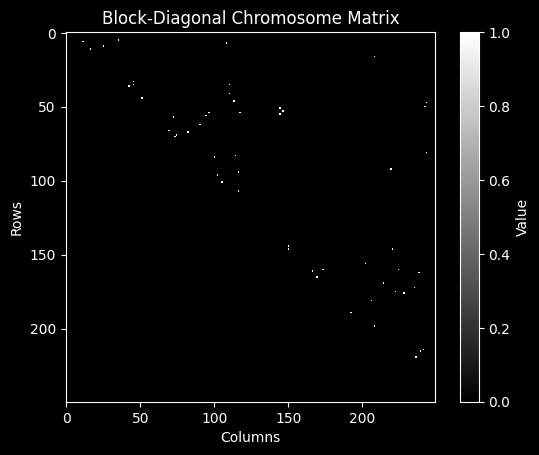

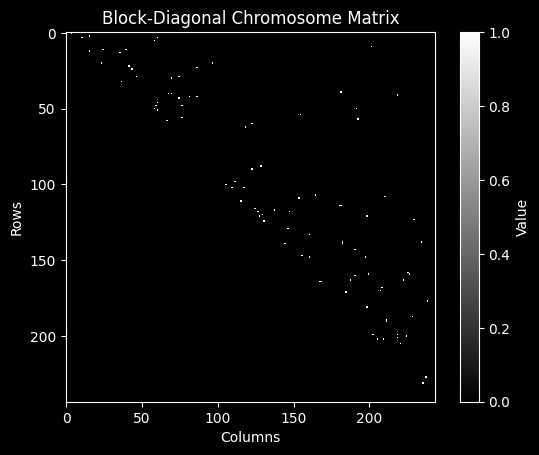

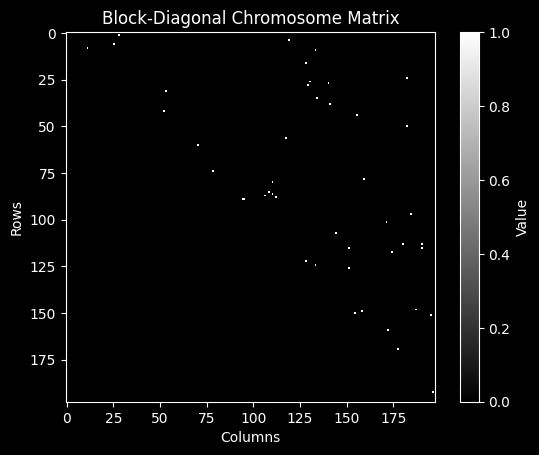

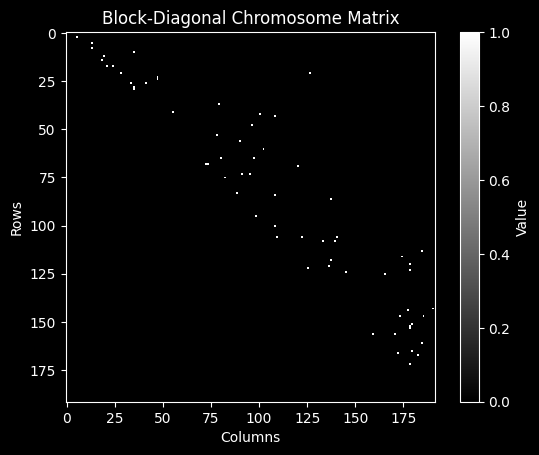

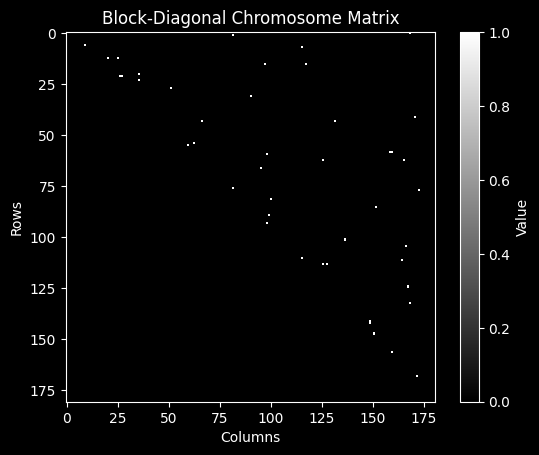

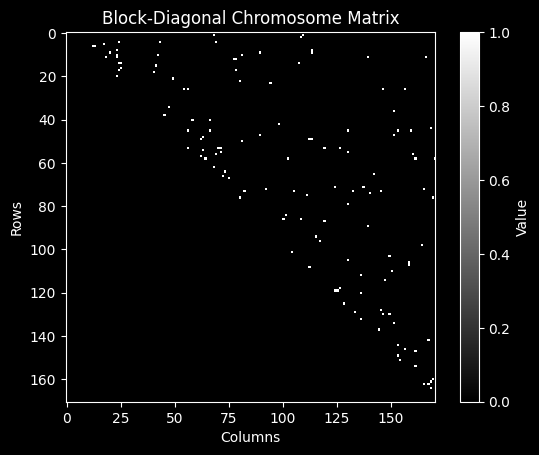

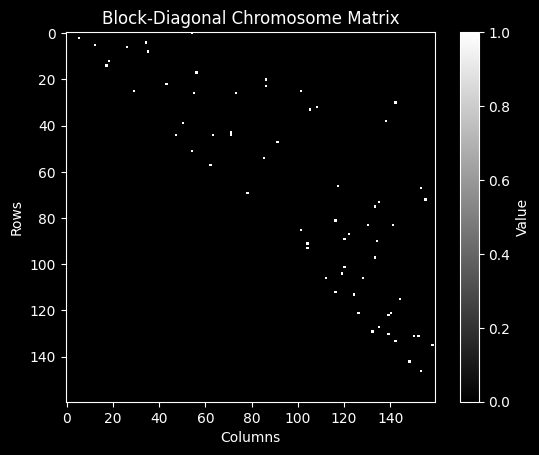

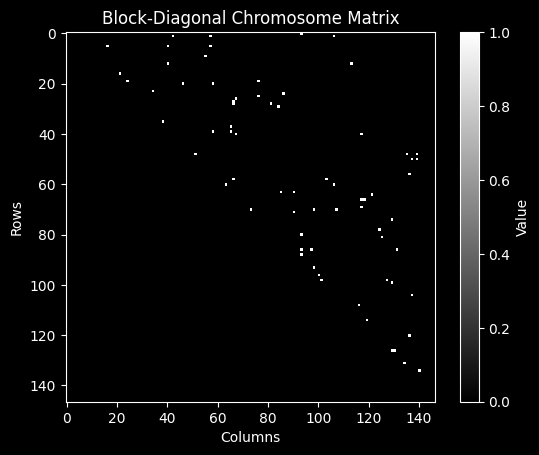

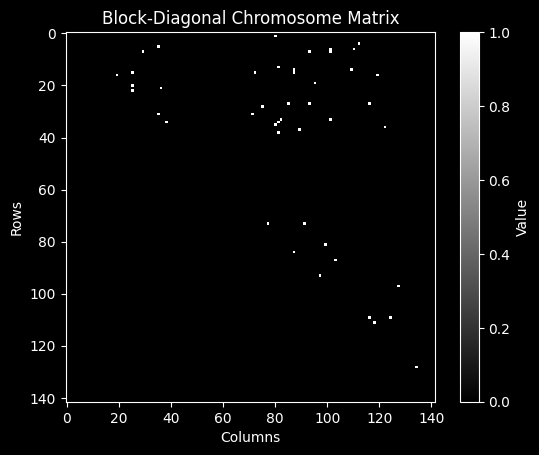

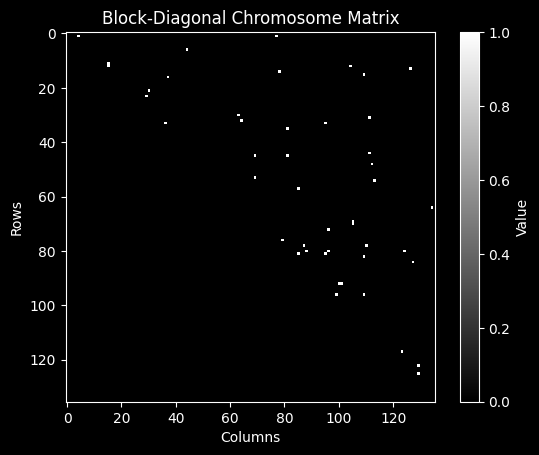

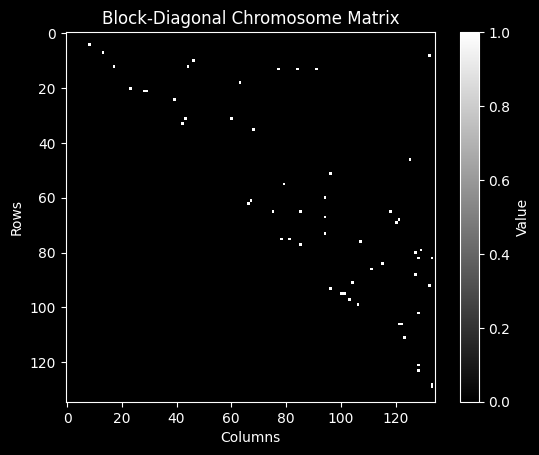

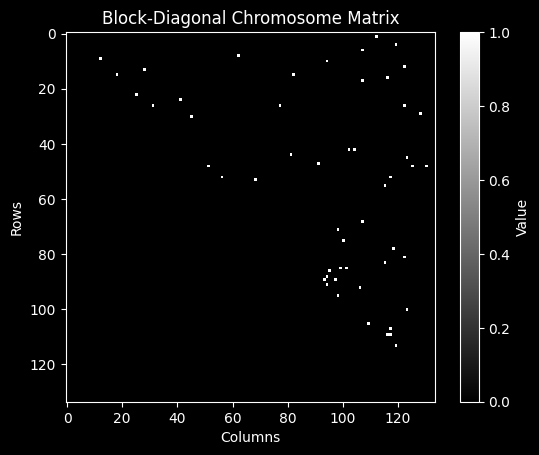

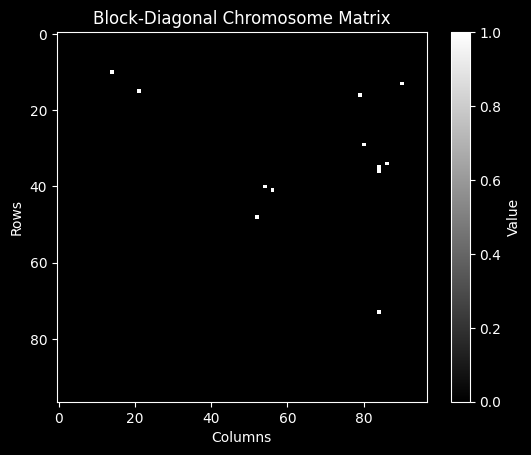

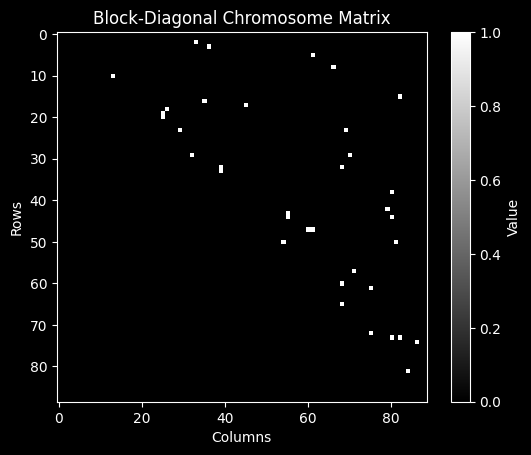

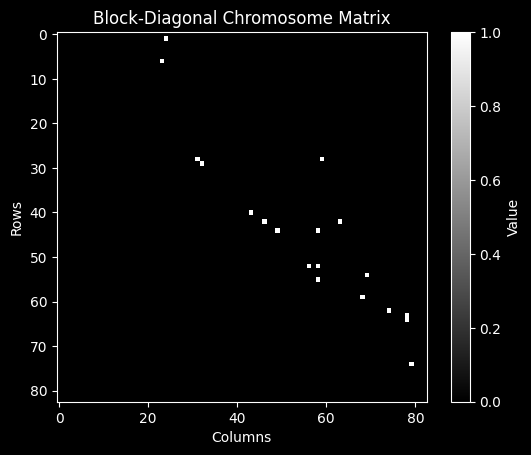

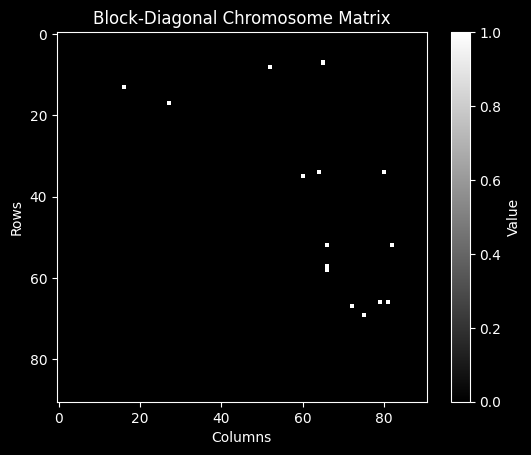

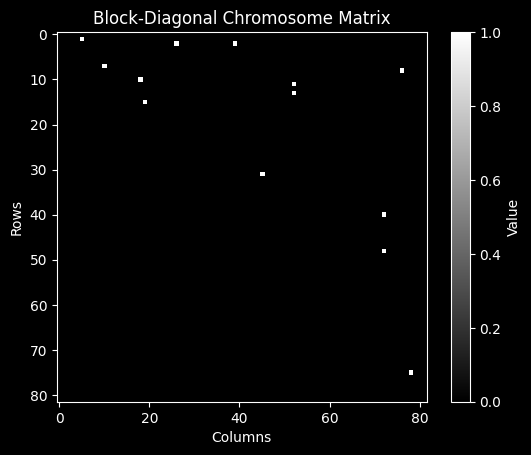

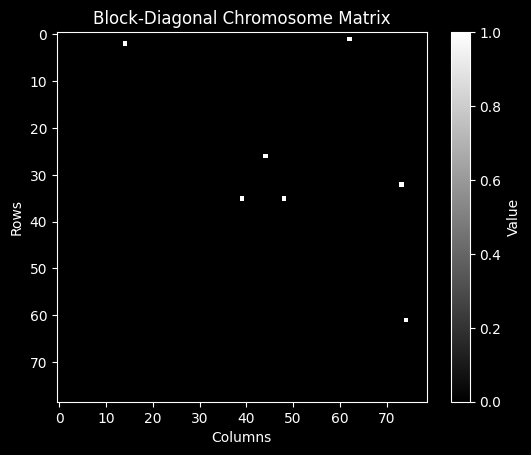

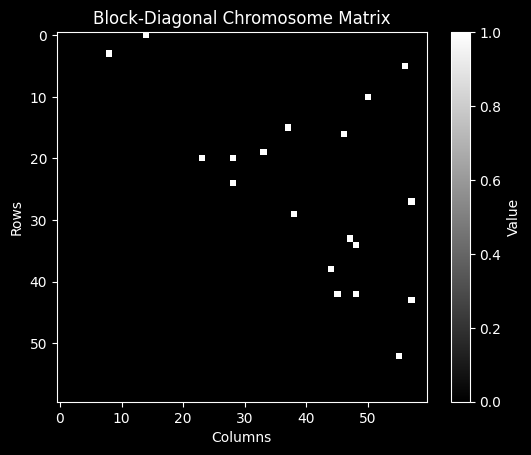

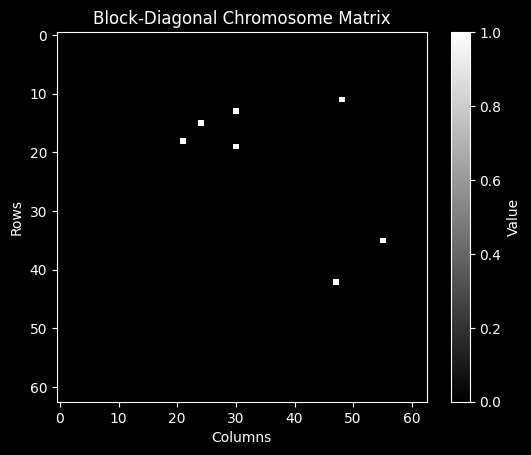

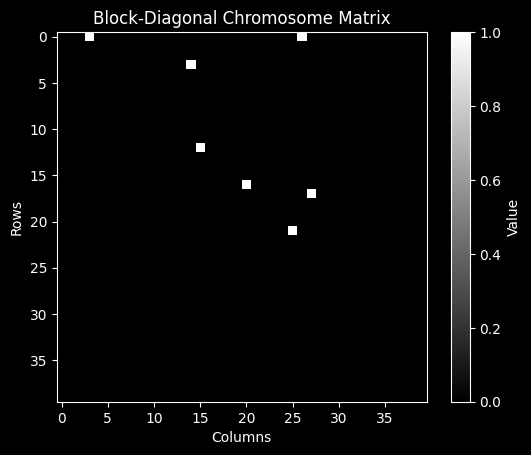

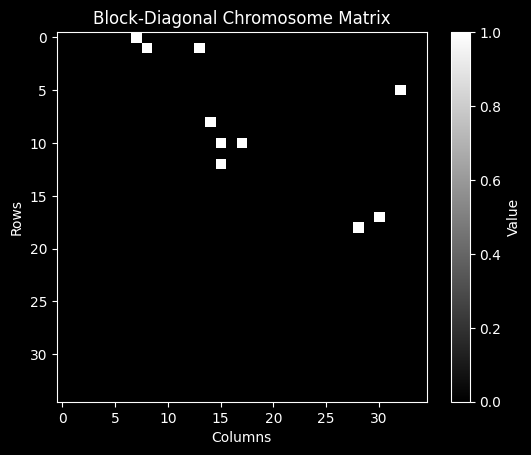

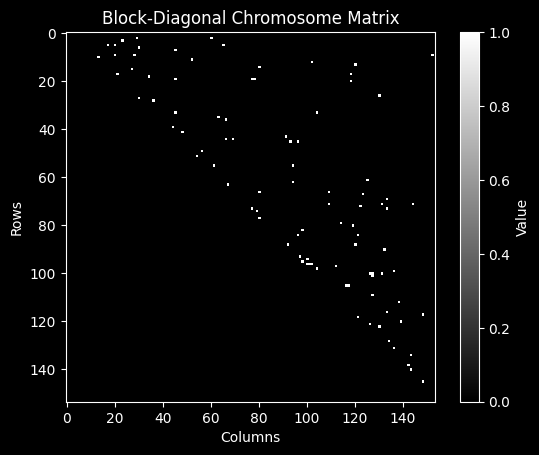

In [ ]:
# for i in range(23):
#     visualize(sample_matrix_list[i])

In [9]:
GM12878_MATRICES_FIXED_SIZE = []
HAP1_MATRICES_FIXED_SIZE = []
Hela_MATRICES_FIXED_SIZE = []
K562_MATRICES_FIXED_SIZE = []

for file in tqdm(os.listdir("GM12878")):
    if file.endswith(".txt"):
        data = parse_file(f"GM12878/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            GM12878_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("HAP1")):
    if file.endswith(".txt"):
        data = parse_file(f"HAP1/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            HAP1_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("Hela")):
    if file.endswith(".txt"):
        data = parse_file(f"Hela/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            Hela_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("K562")):
    if file.endswith(".txt"):
        data = parse_file(f"K562/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            K562_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

100%|██████████| 48/48 [00:04<00:00,  9.72it/s]


In [11]:
sample_num = 20
# Sample a subset from HAP1 and Hela matrices
HAP1_sample = random.sample(HAP1_MATRICES_FIXED_SIZE, sample_num)
Hela_sample = random.sample(Hela_MATRICES_FIXED_SIZE, sample_num)
GM12878_sample = random.sample(GM12878_MATRICES_FIXED_SIZE, sample_num)
K562_sample = random.sample(K562_MATRICES_FIXED_SIZE, sample_num)

In [12]:
GM12878_M = dimensionality_reduce_list_parallel(
    GM12878_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1  # Use all available CPU cores
)

K562_M = dimensionality_reduce_list_parallel(
    K562_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

HAP1_M = dimensionality_reduce_list_parallel(
    HAP1_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

Hela_M = dimensionality_reduce_list_parallel(
    Hela_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

In [14]:
for i in range(20):
    print(GM12878_sample[i].shape)

(2917, 2917)
(2917, 2917)
(2930, 2930)
(2943, 2943)
(2927, 2927)
(2944, 2944)
(2945, 2945)
(2917, 2917)
(2932, 2932)
(2900, 2900)
(2926, 2926)
(2933, 2933)
(2913, 2913)
(2931, 2931)
(2952, 2952)
(2927, 2927)
(2949, 2949)
(2946, 2946)
(2949, 2949)
(2922, 2922)


In [13]:
def flatten_matrices(matrix_list):
    """
    Flattens a list of 2D matrices into a 2D array where each row is a flattened matrix.
    """
    return np.array([matrix.flatten() for matrix in matrix_list])

# Flatten the sampled matrices
HAP1_flat = flatten_matrices(HAP1_sample)
Hela_flat = flatten_matrices(Hela_sample)
GM12878_flat = flatten_matrices(GM12878_sample)
K562_flat = flatten_matrices(K562_sample)

# Combine all data into a single feature matrix
X = np.vstack((HAP1_flat, Hela_flat, GM12878_flat, K562_flat))

# Create labels for each group
labels = (
    ['HAP1'] * len(HAP1_flat) +
    ['Hela'] * len(Hela_flat) +
    ['GM12878'] * len(GM12878_flat) +
    ['K562'] * len(K562_flat)
)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20,) + inhomogeneous part.